# Model CNN

## Import Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Preprocessing

In [3]:
data_dir = 'Data'      
img_size = (128, 128)   

images = []
labels = []

classes = sorted(os.listdir(data_dir))
print("Detected classes:", classes)

for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
        
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            # Load and resize
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_file}: {e}")

X = np.array(images, dtype="float32") / 255.0   # normalize pixels
y = np.array(labels)

print(f"Total images: {len(X)}")
print(f"Image shape: {X.shape}")

y_cat = to_categorical(y, num_classes=len(classes))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Detected classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9', 'files.txt']
Error loading .ipynb_checkpoints: [Errno 13] Permission denied: 'Data\\0\\.ipynb_checkpoints'
Error loading .ipynb_checkpoints: [Errno 13] Permission denied: 'Data\\16\\.ipynb_checkpoints'
Error loading .ipynb_checkpoints: [Errno 13] Permission denied: 'Data\\2\\.ipynb_checkpoints'
Total images: 1360
Image shape: (1360, 128, 128, 3)
Training samples: 1088
Testing samples: 272


## CNN Model Training

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import os

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

num_classes = y_train.shape[1]  # Make sure this is 18

cnn_model = Sequential([
    Input(shape=(128,128,3)),   # Correct input definition
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Correct number of classes
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

cnn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

history_cnn = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,   # Increase if dataset is small
    validation_data=(X_test, y_test)
)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,650,642 (25.37 MB)

 Trainable params: 6,650,642 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\kgadg\anaconda3\envs\Deep_Learning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 421ms/step - accuracy: 0.1007 - loss: 2.7958 - val_accuracy: 0.1949 - val_loss: 2.3793
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 413ms/step - accuracy: 0.1926 - loss: 2.3481 - val_accuracy: 0.2721 - val_loss: 2.0279
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 389ms/step - accuracy: 0.3114 - loss: 2.0302 - val_accuracy: 0.4191 - val_loss: 1.5450
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 400ms/step - accuracy: 0.4381 - loss: 1.6856 - val_accuracy: 0.4743 - val_loss: 1.4232
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.5031 - loss: 1.5347 - val_accuracy: 0.5735 - val_loss: 1.2678
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - accuracy: 0.4946 - loss: 1.4714 - val_accuracy: 0.6066 - val_loss: 1.1946
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 386ms/step - accuracy: 0.5808 - loss: 1.2654 - val_accuracy: 0.5772 - val_loss: 1.1577
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.5777 - loss: 1.2348 - val_accu

In [5]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7374 - loss: 1.0408
Test Accuracy: 0.7500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


## Classification Report

In [6]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=classes[:len(np.unique(y_true))]))





Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.38      0.43        16
           1       0.61      0.69      0.65        16
          10       1.00      0.94      0.97        16
          11       0.39      0.44      0.41        16
          12       0.67      0.88      0.76        16
          13       0.65      0.69      0.67        16
          14       0.80      0.75      0.77        16
          15       0.72      0.81      0.76        16
          16       0.86      0.75      0.80        16
           2       0.86      0.75      0.80        16
           3       0.87      0.81      0.84        16
           4       0.86      0.75      0.80        16
           5       0.82      0.88      0.85        16
           6       0.94      1.00      0.97        16
           7       0.45      0.31      0.37        16
           8       0.80      1.00      0.89        16
           9       0.94      0.94      0.94        16

 

## Confusion Matrix

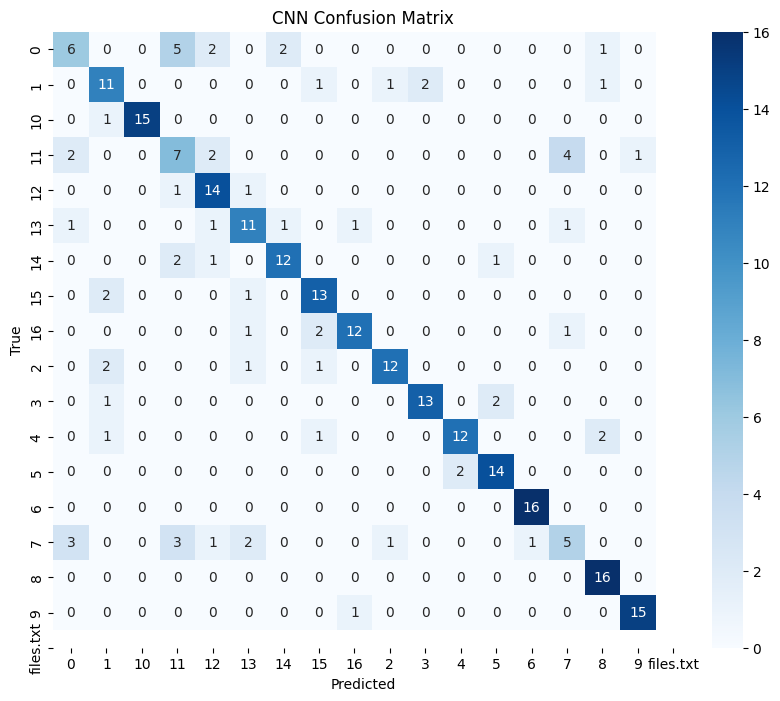

In [7]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



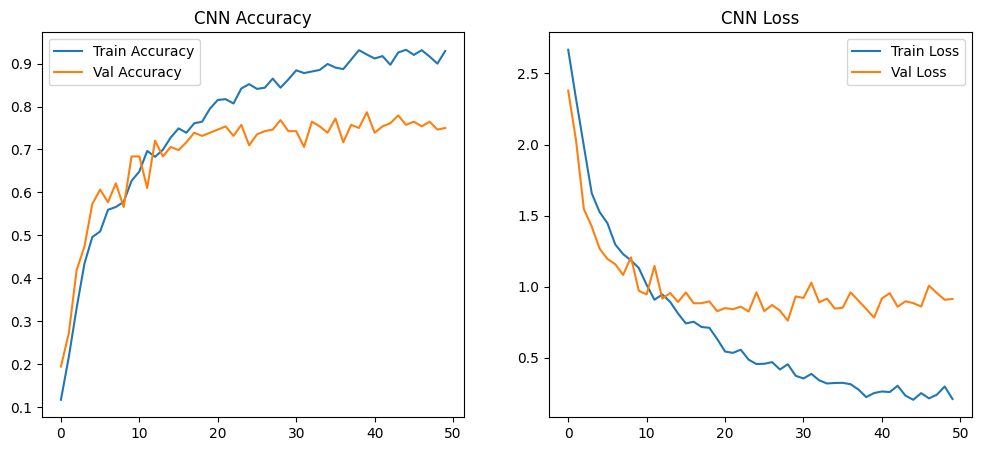

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.legend()
plt.show()

## Model Saving

In [26]:
cnn_model.save("flowers17_model_cnn.h5")


In [27]:
import os
print(os.path.exists("flowers17_model_cnn.h5"))


True


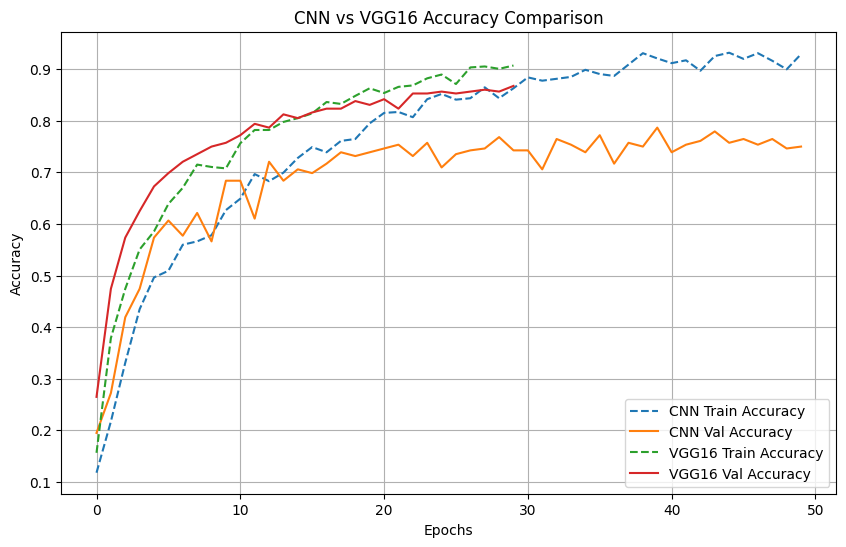

In [10]:
import matplotlib.pyplot as plt

# --- Combine VGG16 training stages (top + fine-tuning) ---
vgg_train_acc = history_top.history['accuracy'] + history_finetune.history['accuracy']
vgg_val_acc = history_top.history['val_accuracy'] + history_finetune.history['val_accuracy']

# --- CNN accuracy ---
cnn_train_acc = history_cnn.history['accuracy']
cnn_val_acc = history_cnn.history['val_accuracy']

# --- Plot comparison ---
plt.figure(figsize=(10,6))
plt.plot(cnn_train_acc, label='CNN Train Accuracy', linestyle='--')
plt.plot(cnn_val_acc, label='CNN Val Accuracy')
plt.plot(vgg_train_acc, label='VGG16 Train Accuracy', linestyle='--')
plt.plot(vgg_val_acc, label='VGG16 Val Accuracy')
plt.title('CNN vs VGG16 Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


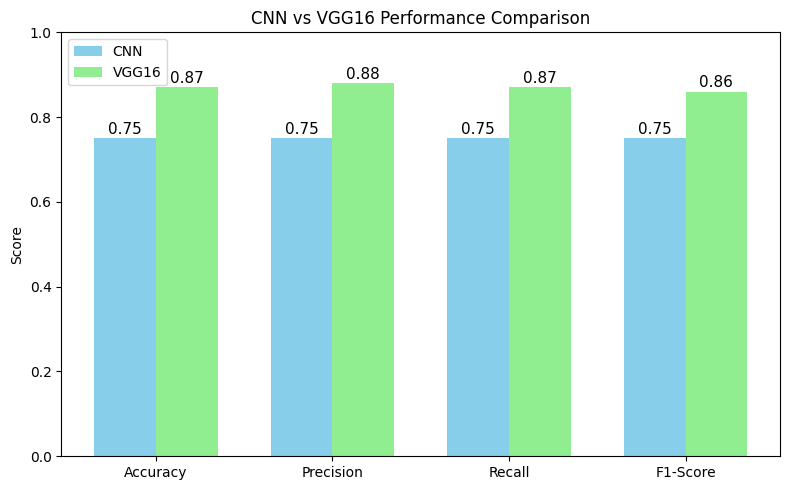

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --- Metrics from classification reports ---
cnn_metrics = {
    "Accuracy": 0.75,
    "Precision": 0.75,
    "Recall": 0.75,
    "F1-Score": 0.75
}

vgg_metrics = {
    "Accuracy": 0.87,
    "Precision": 0.88,
    "Recall": 0.87,
    "F1-Score": 0.86
}

# --- Create bar chart ---
metrics = list(cnn_metrics.keys())
cnn_values = list(cnn_metrics.values())
vgg_values = list(vgg_metrics.values())

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, cnn_values, width, label='CNN', color='skyblue')
plt.bar(x + width/2, vgg_values, width, label='VGG16', color='lightgreen')

plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('CNN vs VGG16 Performance Comparison')
plt.legend()

# Add values on top of bars
for i in range(len(metrics)):
    plt.text(x[i] - width/2, cnn_values[i] + 0.01, f"{cnn_values[i]:.2f}", ha='center', fontsize=11)
    plt.text(x[i] + width/2, vgg_values[i] + 0.01, f"{vgg_values[i]:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


## Testing

Model class order alignment:
 0 → daffodil
 1 → snowdrop
 2 → daisy
 3 → coltsfoot
 4 → dandelion
 5 → cowslip
 6 → buttercup
 7 → windflower
 8 → pansy
 9 → lily_valley
10 → bluebell
11 → crocus
12 → iris
13 → tigerlily
14 → tulip
15 → fritillary
16 → sunflower
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


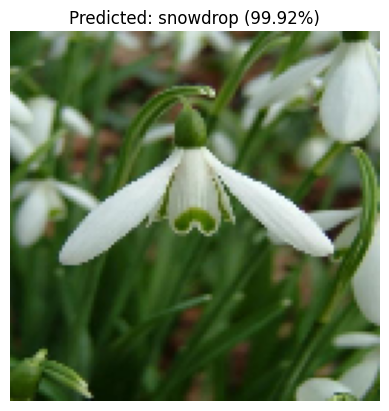

Custom CNN predicts: snowdrop (99.92%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


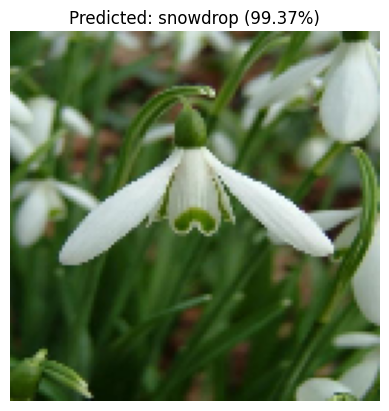

VGG16 predicts: snowdrop (99.37%)


In [40]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, img_path, class_names, target_size=(128,128)):
    """
    model: trained Keras model (cnn_model or vgg_model)
    img_path: path to the image file
    class_names: list of class labels
    target_size: input size expected by the model
    """
    # Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    pred = model.predict(img_array)
    class_index = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred)
    class_label = class_names[class_index]

    # Show image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    return class_label, confidence


flower_names = [
    "daffodil", "snowdrop", "lily_valley", "bluebell", "crocus", "iris", "tigerlily",
    "tulip", "fritillary", "sunflower", "daisy", "coltsfoot", "dandelion",
    "cowslip", "buttercup", "windflower", "pansy"
]

data_dir = "Data"
classes_lex = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
aligned_flower_names = [flower_names[int(folder)] for folder in classes_lex]

print("Model class order alignment:")
for i, name in enumerate(aligned_flower_names):
    print(f"{i:2d} → {name}")


img_path = "Data/1/image_0082.jpg"  

# Predict using your trained models
predicted_class_cnn, conf_cnn = predict_image(cnn_model, img_path, aligned_flower_names)
print(f"Custom CNN predicts: {predicted_class_cnn} ({conf_cnn*100:.2f}%)")

predicted_class_vgg, conf_vgg = predict_image(vgg_model, img_path, aligned_flower_names)
print(f"VGG16 predicts: {predicted_class_vgg} ({conf_vgg*100:.2f}%)")
